In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import math
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 16})

#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid = False)

random_state = 42

In [2]:
listings = pd.read_csv('./listings.csv')
zipcodes = pd.Series(listings['zipcode'].unique()).dropna()
demographics = pd.read_csv('./demographics.csv')

In [3]:
listings['overall_activity'] = np.array(listings['availability_30'])*np.array(listings['accommodates'])

In [66]:
listings[listings['state'] == 'NC']['host_id']

0       2600734
1       4295819
2      36223353
3        746673
4        746673
         ...   
859    24938934
860     3572350
861    22017512
862    18064036
863    60352462
Name: host_id, Length: 864, dtype: int64

In [5]:
number_of_properties = []
overall_activity = []
overall_capacity = []
overall_availability = []
dzip = {}

for z in zipcodes:
    number_of_properties.append(len(listings[listings['zipcode'] == z]))
    overall_activity.append(sum(listings[listings['zipcode'] == z]['overall_activity']))
    overall_capacity.append(sum(listings[listings['zipcode'] == z]['accommodates']))
    overall_availability.append(sum(listings[listings['zipcode'] == z]['availability_30']))
    dzip[z] = listings[listings['zipcode'] == z]['state'].unique()[0]

In [6]:
dfzip = pd.DataFrame()
dfzip['zipcodes'] = zipcodes
dfzip['number_of_listings'] = number_of_properties
dfzip['overall_capacity'] = overall_capacity
dfzip['overall_availability'] = overall_availability
dfzip['overall_activity'] = overall_activity

# Part 1: Cleaning zipcodes data

In [7]:
def clean(zipcode):
    # str to int
    if zipcode != zipcode:
        return np.nan
    elif  len(zipcode.split('.')) > 1:
        return int(zipcode.split('.')[0])
    elif len(zipcode.split('-')) > 1:
        return int(zipcode.split('-')[0])
    elif len(zipcode.split(':')) > 1:
        return int(zipcode.split(':')[0])
    elif len(zipcode.split(' ')) > 1:
        if len(zipcode.split(' ')) == 2:
            return int(zipcode.split(' ')[1])
        else:
            return int(zipcode.split(' ')[0])
        
    elif len(zipcode.split('\n')) > 1:
        return int(zipcode.split('\n')[0])
    else:
        return int(zipcode)

In [8]:
clean_zipcodes = []
states_of_clean_zipcodes = []

for i in zipcodes:
    clean_zipcodes.append(clean(i))
    states_of_clean_zipcodes.append(dzip[i])

In [9]:
dfzip['zipcode'] = clean_zipcodes
dfzip['state'] = states_of_clean_zipcodes
dfzip

,zipcodes,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,state
0,28806.0,239,821.0,3412,11103.0,28806,NC
1,28801.0,203,660.0,2590,8991.0,28801,NC
2,28803.0,115,446.0,1916,7246.0,28803,NC
3,28805.0,98,358.0,1433,5079.0,28805,NC
4,28804.0,121,449.0,1984,7181.0,28804,NC
...,...,...,...,...,...,...,...
425,91361,7,15.0,181,397.0,91361,CA
426,91306,39,122.0,817,2589.0,91306,CA
427,90606,3,25.0,28,305.0,90606,CA
428,90095,2,9.0,32,183.0,90095,CA


# Part 2: Combining demographic and Airbnb data for the postcodes, adding extra features

In [10]:
df_new = pd.merge(dfzip, demographics, on = 'zipcode')
df_new

,zipcodes,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,state,population,5_years_or_less,5-9_years,...,"$9,999_or_less","$10,000-$14,999","$15,000-$24,999","$25,000-$34,999","$35,000-$49,999","$50,000-$64,999","$65,000-$74,999","$75,000_or_more",median_household_income,mean_household_income
0,28806.0,239,821.0,3412,11103.0,28806,NC,40326,2613,2687,...,7.7,9.1,13.2,11.9,20.3,18,9,10.8,41208,50635
1,28801.0,203,660.0,2590,8991.0,28801,NC,14300,689,457,...,12.2,12.9,15.1,13.9,12.6,13.1,5.9,14.3,31359,52163
2,28803.0,115,446.0,1916,7246.0,28803,NC,31478,2083,1992,...,6.7,6.8,9.5,11.8,16.9,18.6,9.7,20.0,47474,72934
3,28805.0,98,358.0,1433,5079.0,28805,NC,18010,808,1019,...,4.7,8.8,14.5,11.6,14.2,15.9,12.6,17.7,45335,63223
4,28804.0,121,449.0,1984,7181.0,28804,NC,21047,765,1095,...,5.7,5.6,10.6,11.2,16.7,16.2,9.7,24.3,50193,79470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412,91361,7,15.0,181,397.0,91361,CA,20831,806,900,...,4.1,2,4.2,5.7,7.3,10.7,13,53.0,104807,156405
413,91306,39,122.0,817,2589.0,91306,CA,49532,3024,3230,...,4.4,5.1,8.2,10.9,12.4,17.6,14.9,26.5,61529,74726
414,90606,3,25.0,28,305.0,90606,CA,32697,1772,2070,...,3.9,4.4,8,9.8,13,20.2,15.9,24.8,64393,74385
415,90095,2,9.0,32,183.0,90095,CA,0,0,0,...,-,-,-,-,-,-,-,100.0,-,-


In [11]:
df_new['$9,999_or_less']

0       7.7
1      12.2
2       6.7
3       4.7
4       5.7
       ... 
412     4.1
413     4.4
414     3.9
415       -
416       5
Name: $9,999_or_less, Length: 417, dtype: object

In [126]:
l1 = list(dfzip['zipcode'])
l2 = list(df_new['zipcode'])

list(set(l1) - set(l2))
# whatever

[90625,
 999041,
 91523,
 70148,
 9004,
 91308,
 90929,
 210,
 78774,
 90840,
 91802,
 701115]

In [127]:
for el in list(set(l1) - set(l2)):
    print(dfzip[dfzip['zipcode'] == el])



    zipcodes  number_of_listings  overall_capacity  overall_availability  \
368    90625                   1              10.0                    20   

     overall_activity  zipcode state  
368             200.0    90625    CA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
416   999041                   1               2.0                     0   

     overall_activity  zipcode state  
416               0.0   999041    CA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
220    91523                   1               4.0                    13   

     overall_activity  zipcode state  
220              52.0    91523    CA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \
115    70148                   1               8.0                    30   

     overall_activity  zipcode state  
115             240.0    70148    LA  
    zipcodes  number_of_listings  overall_capacity  overall_availability  \


In [13]:
df_new['median_household_income'] = df_new['median_household_income'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['mean_household_income'] = df_new['mean_household_income'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['$9,999_or_less'] = df_new['$9,999_or_less'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$10,000-$14,999'] = df_new['$10,000-$14,999'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['$15,000-$24,999'] = df_new['$15,000-$24,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$25,000-$34,999'] = df_new['$25,000-$34,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$35,000-$49,999'] = df_new['$35,000-$49,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$50,000-$64,999'] = df_new['$50,000-$64,999'].apply(lambda el: np.nan if el == '-' else float(el))
df_new['$65,000-$74,999'] = df_new['$65,000-$74,999'].apply(lambda el: np.nan if el == '-' else float(el))

df_new['5_years_or_less_fr'] = df_new['5_years_or_less']/df_new['population']
df_new['5-9_years_fr'] = df_new['5-9_years']/df_new['population']
df_new['10-14_years_fr'] = df_new['10-14_years']/df_new['population']
df_new['15-19_years_fr'] = df_new['15-19_years']/df_new['population']
df_new['20-24_years_fr'] = df_new['20-24_years']/df_new['population']
df_new['25-34_years_fr'] = df_new['25-34_years']/df_new['population']
df_new['35-44_years_fr'] = df_new['35-44_years']/df_new['population']
df_new['45-54_years_fr'] = df_new['45-54_years']/df_new['population']

df_new['55-59_years_fr'] = df_new['55-59_years']/df_new['population']
df_new['60-64_years_fr'] = df_new['60-64_years']/df_new['population']
df_new['65-74_years_fr'] = df_new['65-74_years']/df_new['population']
df_new['75-84_years_fr'] = df_new['75-84_years']/df_new['population']
df_new['85_years_or_more_fr'] = df_new['85_years_or_more']/df_new['population']

In [14]:
corr = df_new.corr()
corr

,number_of_listings,overall_capacity,overall_availability,overall_activity,zipcode,population,5_years_or_less,5-9_years,10-14_years,15-19_years,...,15-19_years_fr,20-24_years_fr,25-34_years_fr,35-44_years_fr,45-54_years_fr,55-59_years_fr,60-64_years_fr,65-74_years_fr,75-84_years_fr,85_years_or_more_fr
number_of_listings,1.000000,0.982450,0.985631,0.961373,-0.033753,0.026056,-0.080049,-0.128588,-0.171456,-0.105522,...,-0.178429,0.130111,0.468113,0.204793,-0.157687,-0.114754,-0.061947,-0.088995,-0.108227,-0.035872
overall_capacity,0.982450,1.000000,0.971315,0.983913,-0.085906,-0.012881,-0.101110,-0.142824,-0.185496,-0.126280,...,-0.171097,0.112096,0.445445,0.169193,-0.150035,-0.086705,-0.032754,-0.075226,-0.104509,-0.040323
overall_availability,0.985631,0.971315,1.000000,0.978987,-0.029607,0.026292,-0.082231,-0.127211,-0.167082,-0.114878,...,-0.195502,0.091278,0.447769,0.199427,-0.125415,-0.081173,-0.026155,-0.058644,-0.084695,-0.018159
overall_activity,0.961373,0.983913,0.978987,1.000000,-0.081771,-0.023301,-0.112979,-0.149863,-0.189194,-0.140915,...,-0.185913,0.074613,0.419330,0.157797,-0.115573,-0.048657,0.008285,-0.038145,-0.072787,-0.018083
zipcode,-0.033753,-0.085906,-0.029607,-0.081771,1.000000,0.222710,0.168821,0.172502,0.219016,0.215199,...,0.051256,-0.019880,-0.100466,0.091933,0.054914,-0.035436,-0.158794,-0.092425,0.049445,0.059951
population,0.026056,-0.012881,0.026292,-0.023301,0.222710,1.000000,0.931885,0.926850,0.926512,0.881703,...,0.133714,0.145798,0.016201,0.013426,-0.201373,-0.257528,-0.300994,-0.315404,-0.225442,-0.199610
5_years_or_less,-0.080049,-0.101110,-0.082231,-0.112979,0.168821,0.931885,1.000000,0.971923,0.944021,0.848300,...,0.140355,0.101915,0.013498,0.037306,-0.242982,-0.315798,-0.384710,-0.416054,-0.323632,-0.273898
5-9_years,-0.128588,-0.142824,-0.127211,-0.149863,0.172502,0.926850,0.971923,1.000000,0.971849,0.870481,...,0.176200,0.074871,-0.083238,0.002349,-0.192725,-0.279668,-0.358299,-0.374994,-0.296164,-0.269636
10-14_years,-0.171456,-0.185496,-0.167082,-0.189194,0.219016,0.926512,0.944021,0.971849,1.000000,0.888428,...,0.202498,0.062399,-0.153413,-0.034740,-0.138379,-0.231953,-0.317574,-0.330155,-0.257476,-0.240977
15-19_years,-0.105522,-0.126280,-0.114878,-0.140915,0.215199,0.881703,0.848300,0.870481,0.888428,1.000000,...,0.408978,0.368444,-0.156272,-0.186982,-0.275730,-0.302041,-0.379688,-0.362132,-0.270828,-0.221801


# Part 3: Discussing the correlations

It is clear that the majority of Airbnb listings are in California (so not much point grouping by state), and trends are generally similar for each state. Quite remarkably, the demographic features that (anti)correlate most with Airbnb listings are population FRACTIONS of <5, 5-9, 10-14 and 15-19 yo, 25-34 yo etc BY AGE,  with income <15 k USD and income 50 - 75 k USD BY INCOME. Also, there is not much correlation with the number of households, meaning airbnb prices are driven mostly by other factors (e.g. venues). Almost no correlation with population, enhancing the point that airbnb is driven by venues (or might be). For the purpose of statistical test, we include median income. 

# Part 4: Investigating the patterns in proportion of young adult population (25-44), children population (0-14), low-income households (<15k) and medium-income households (50-75 k).

In [15]:
df2 = pd.DataFrame()

In [16]:
df2['zipcode'] = df_new['zipcode']
df2['state'] = df_new['state']
df2['number_of_listings'] = df_new['number_of_listings']
df2['overall_capacity'] = df_new['overall_capacity']
df2['overall_availability'] = df_new['overall_availability']

df2['children'] = df_new['5_years_or_less_fr'] + df_new['5-9_years_fr'] + df_new['10-14_years_fr']
df2['young_adults'] = df_new['25-34_years_fr'] + df_new['35-44_years_fr'] 

df2['low_income'] = df_new['$9,999_or_less'] + df_new['$10,000-$14,999']
df2['medium_income'] = df_new['$50,000-$64,999'] +df_new['$65,000-$74,999']

df2['median_household_income'] = df_new['median_household_income']
df2['households'] = df_new['households']

In [17]:
df2

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511
2,28803,NC,115,446.0,1916,0.178188,0.281308,13.5,28.3,47474.0,13862
3,28805,NC,98,358.0,1433,0.152915,0.257746,13.5,28.5,45335.0,8483
4,28804,NC,121,449.0,1984,0.134176,0.226018,11.3,25.9,50193.0,8257
...,...,...,...,...,...,...,...,...,...,...,...
412,91361,CA,7,15.0,181,0.145984,0.181652,6.1,23.7,104807.0,8539
413,91306,CA,39,122.0,817,0.175826,0.315998,9.5,32.5,61529.0,14447
414,90606,CA,3,25.0,28,0.182127,0.295256,8.3,36.1,64393.0,8539
415,90095,CA,2,9.0,32,NaN,NaN,NaN,NaN,NaN,0


# Part 5: adding venues data (number per zipcode)

In [18]:
venues_w_zip = pd.read_csv("./venues_w_zip.csv")

places = {}

for zipcode in df2['zipcode'].unique():
    places[zipcode] = 0
    
for index in venues_w_zip.index:
    if clean(venues_w_zip.loc[index]['zipcodes']) in places.keys():
        places[clean(venues_w_zip.loc[index]['zipcodes'])] += 1
        
df2['number_of_venues'] = df2['zipcode'].apply(lambda z: places[z])
df2

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
2,28803,NC,115,446.0,1916,0.178188,0.281308,13.5,28.3,47474.0,13862,863
3,28805,NC,98,358.0,1433,0.152915,0.257746,13.5,28.5,45335.0,8483,449
4,28804,NC,121,449.0,1984,0.134176,0.226018,11.3,25.9,50193.0,8257,427
...,...,...,...,...,...,...,...,...,...,...,...,...
412,91361,CA,7,15.0,181,0.145984,0.181652,6.1,23.7,104807.0,8539,0
413,91306,CA,39,122.0,817,0.175826,0.315998,9.5,32.5,61529.0,14447,0
414,90606,CA,3,25.0,28,0.182127,0.295256,8.3,36.1,64393.0,8539,8
415,90095,CA,2,9.0,32,NaN,NaN,NaN,NaN,NaN,0,146


In [55]:
df2['state'].unique()

array(['NC', 'TX', 'OR', 'TN', 'LA', 'CA'], dtype=object)

In [59]:
df2[df2['state'] == 'NC']

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
2,28803,NC,115,446.0,1916,0.178188,0.281308,13.5,28.3,47474.0,13862,863
3,28805,NC,98,358.0,1433,0.152915,0.257746,13.5,28.5,45335.0,8483,449
4,28804,NC,121,449.0,1984,0.134176,0.226018,11.3,25.9,50193.0,8257,427
5,28787,NC,2,6.0,31,0.162690,0.224621,10.3,31.7,49621.0,7808,214
6,28715,NC,29,107.0,561,0.185041,0.249693,13.4,30.7,45379.0,9971,212
7,28704,NC,30,92.0,541,0.169536,0.243343,8.1,32.0,61279.0,8154,395
8,28732,NC,24,101.0,426,0.180140,0.291963,8.0,32.4,47699.0,6965,218
9,28759,NC,1,6.0,2,0.158885,0.205017,7.7,38.9,62788.0,2740,72


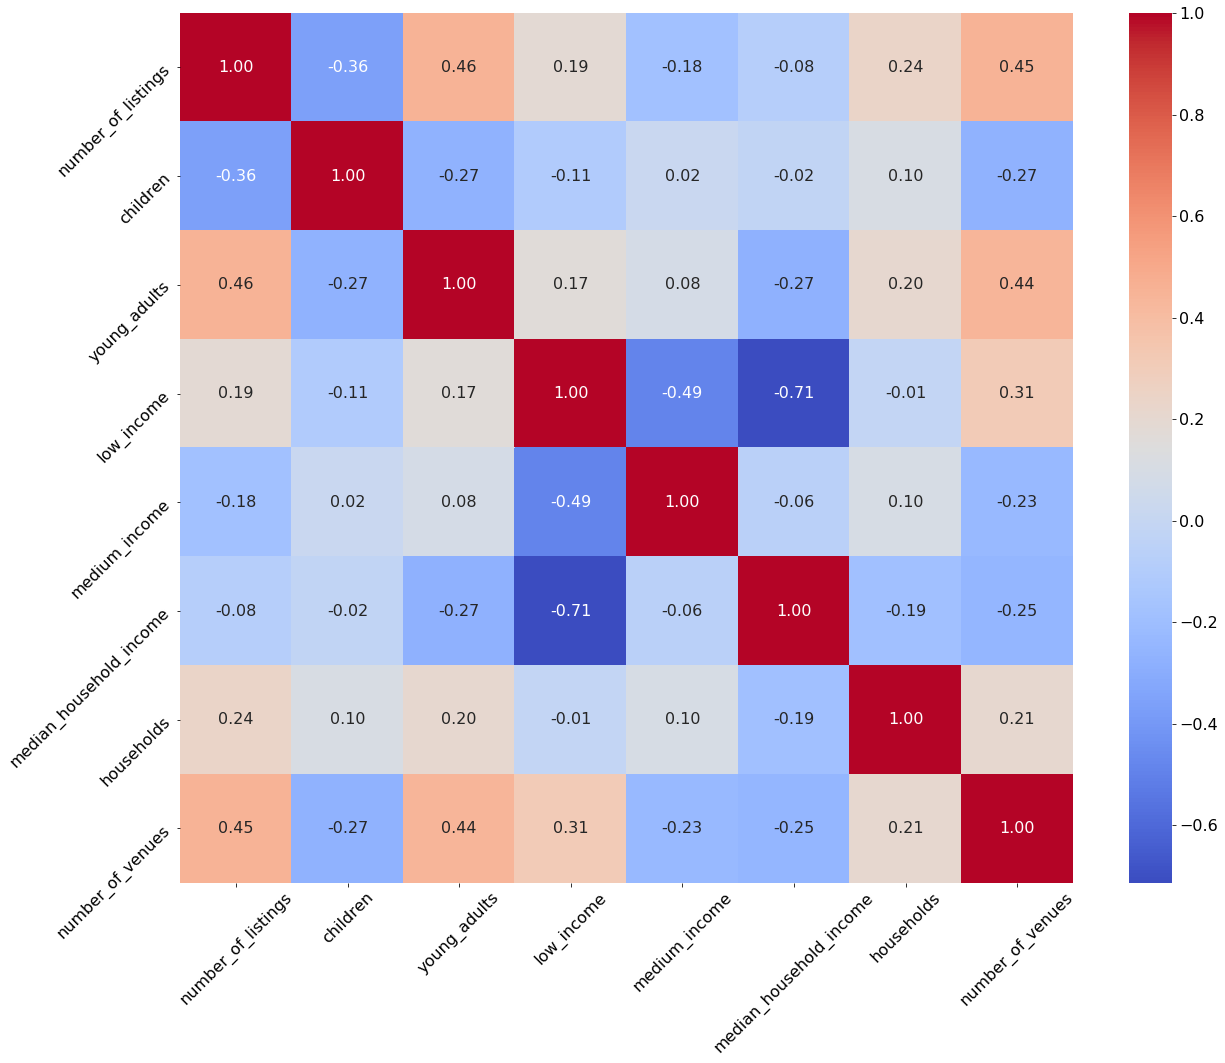

In [19]:
correlation = df2[['number_of_listings', 'children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues']].corr()

plt.figure(figsize = (20, 16))

sns.heatmap(correlation,annot=True, fmt = ".2f", cmap = "coolwarm")
plt.yticks(rotation = 45)
plt.xticks(rotation = 45)
plt.savefig("corrmap.pdf")

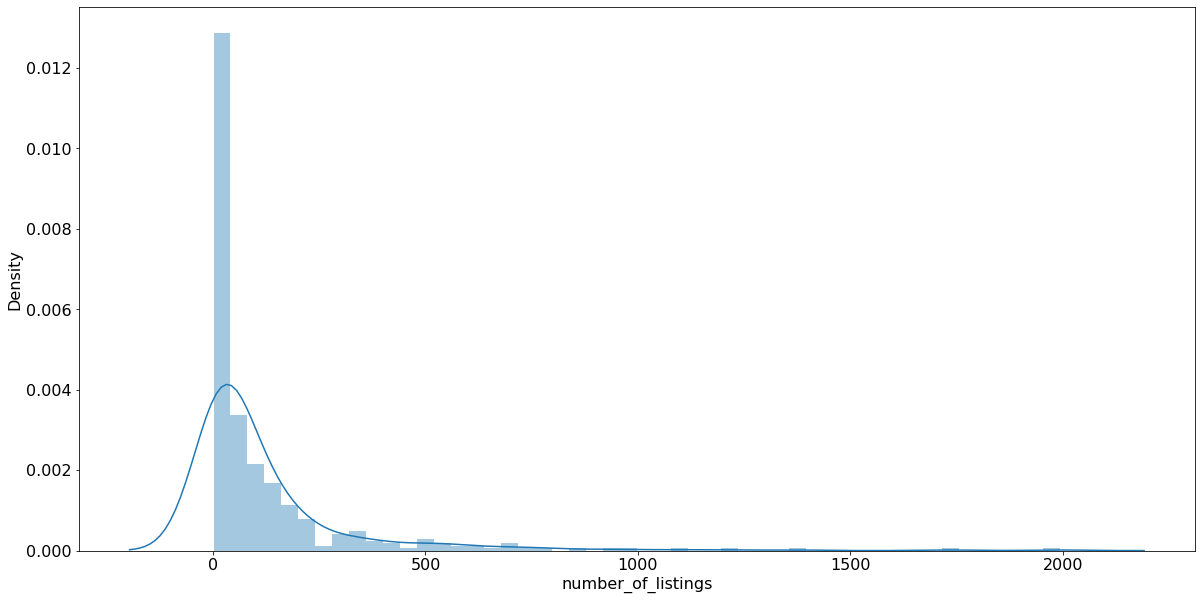

In [20]:
plt.figure(figsize = (20, 10))
sns.distplot(df2['number_of_listings'])

In [21]:
df_low = df2[df2['number_of_listings'] < 200]
#df_medium = df2[(df2['number_of_listings'] > 80) & (df2['number_of_listings'] < 150)]
df_high = df2[df2['number_of_listings'] >= 200]

In [22]:
statistics = pd.DataFrame(index = ['young_adults', 'children', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues'])

In [23]:
statistics['KS p-val'] = [ks_2samp(df_low['young_adults'], df_high['young_adults'])[1], ks_2samp(df_low['children'], df_high['children'])[1], ks_2samp(df_low['low_income'], df_high['low_income'])[1], ks_2samp(df_low['medium_income'], df_high['medium_income'])[1], ks_2samp(df_low['median_household_income'], df_high['median_household_income'])[1], ks_2samp(df_low['households'], df_high['households'])[1], ks_2samp(df_low['number_of_venues'], df_high['number_of_venues'])[1]]

In [24]:
mean_high = []
mean_low = []
stdev_high = []
stdev_low = []

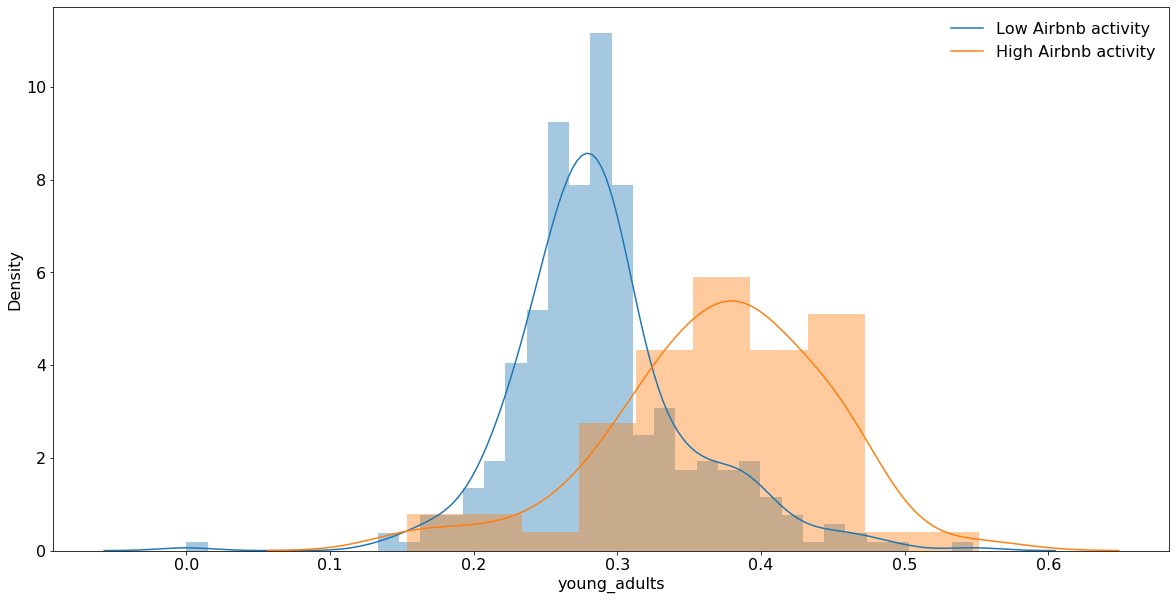

In [25]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['young_adults'])

mean_low.append(df_low['young_adults'].mean())
stdev_low.append(df_low['young_adults'].std())
mean_high.append(df_high['young_adults'].mean())
stdev_high.append(df_high['young_adults'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['young_adults'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

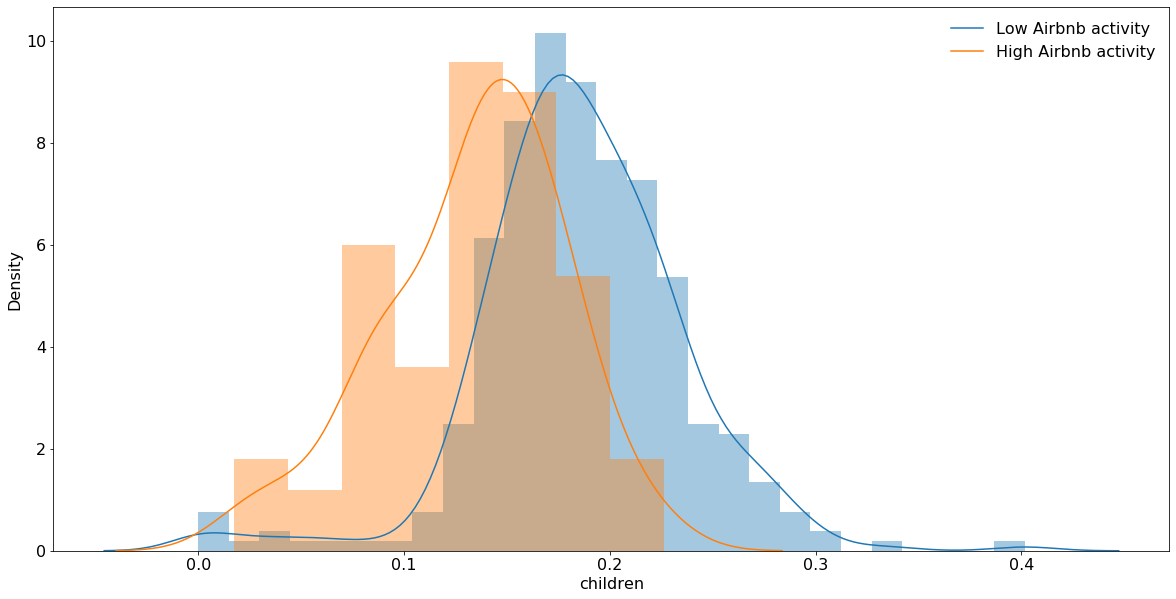

In [26]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['children'])

mean_low.append(df_low['children'].mean())
stdev_low.append(df_low['children'].std())
mean_high.append(df_high['children'].mean())
stdev_high.append(df_high['children'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['children'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

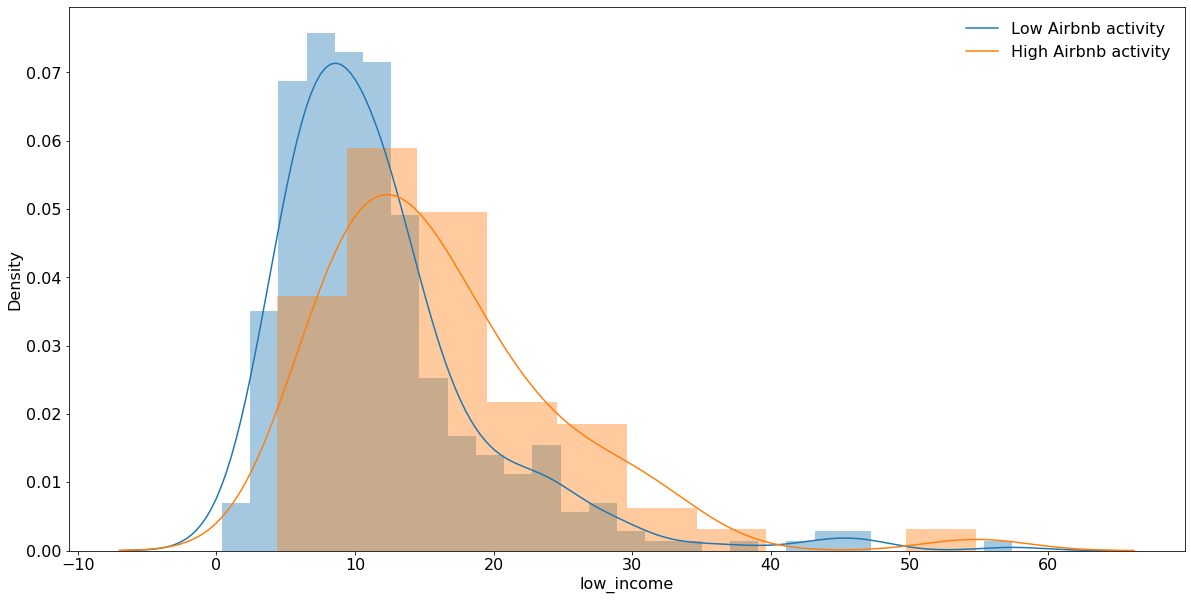

In [27]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['low_income'])

mean_low.append(df_low['low_income'].mean())
stdev_low.append(df_low['low_income'].std())
mean_high.append(df_high['low_income'].mean())
stdev_high.append(df_high['low_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['low_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

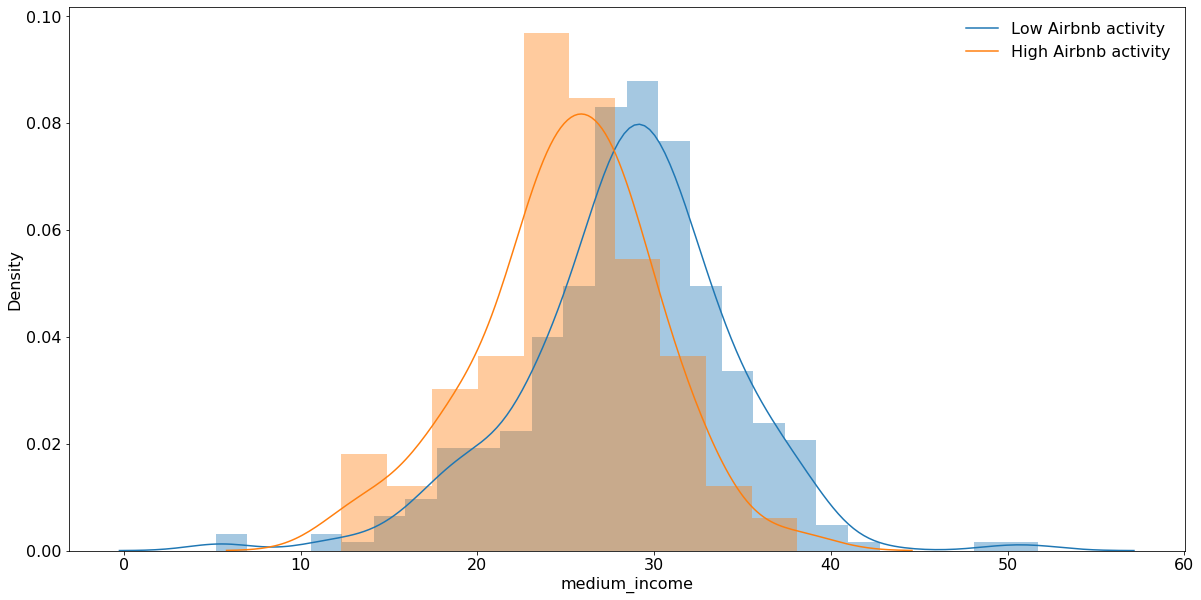

In [28]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['medium_income'])

mean_low.append(df_low['medium_income'].mean())
stdev_low.append(df_low['medium_income'].std())
mean_high.append(df_high['medium_income'].mean())
stdev_high.append(df_high['medium_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['medium_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

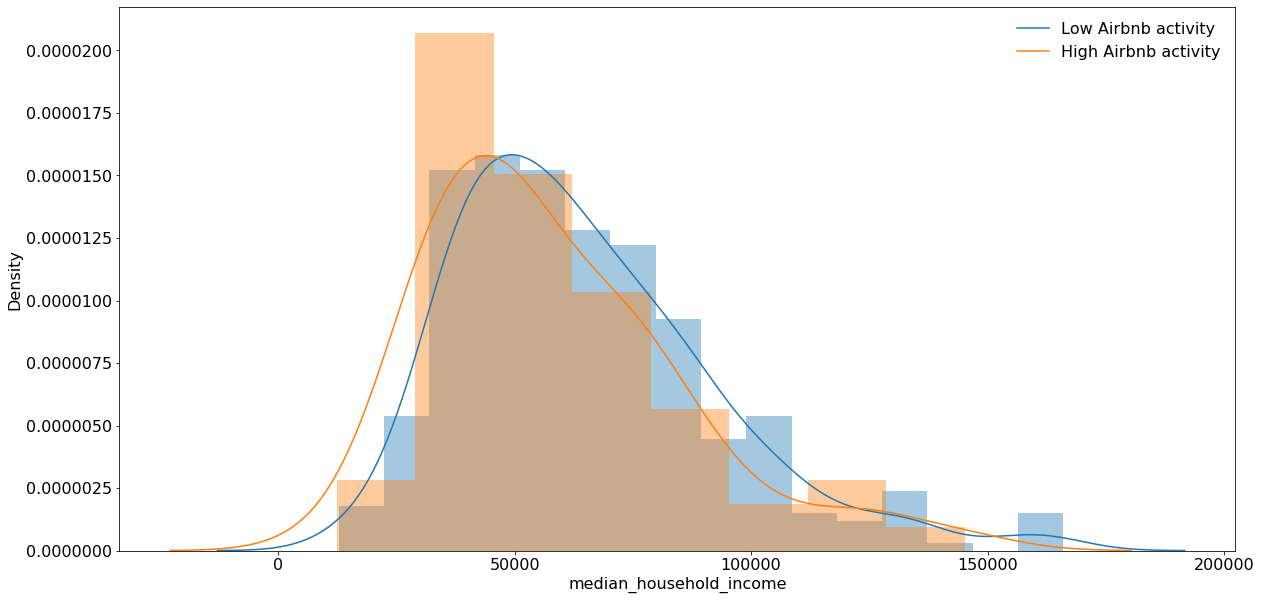

In [29]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['median_household_income'])

mean_low.append(df_low['median_household_income'].mean())
stdev_low.append(df_low['median_household_income'].std())
mean_high.append(df_high['median_household_income'].mean())
stdev_high.append(df_high['median_household_income'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['median_household_income'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

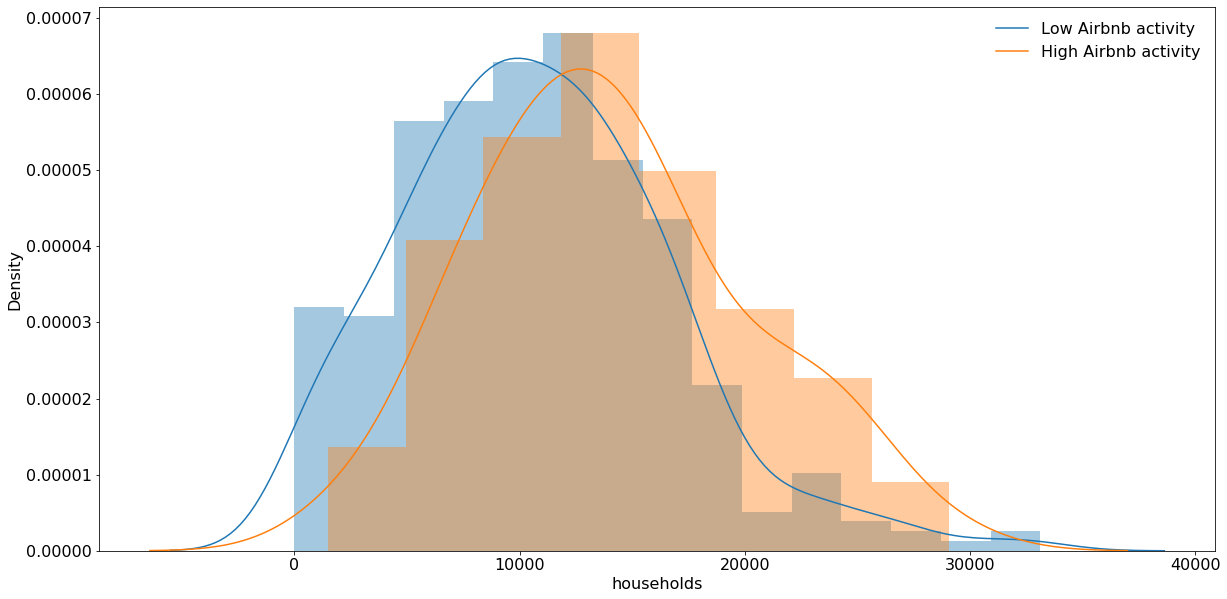

In [30]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['households'])

mean_low.append(df_low['households'].mean())
stdev_low.append(df_low['households'].std())
mean_high.append(df_high['households'].mean())
stdev_high.append(df_high['households'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['households'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

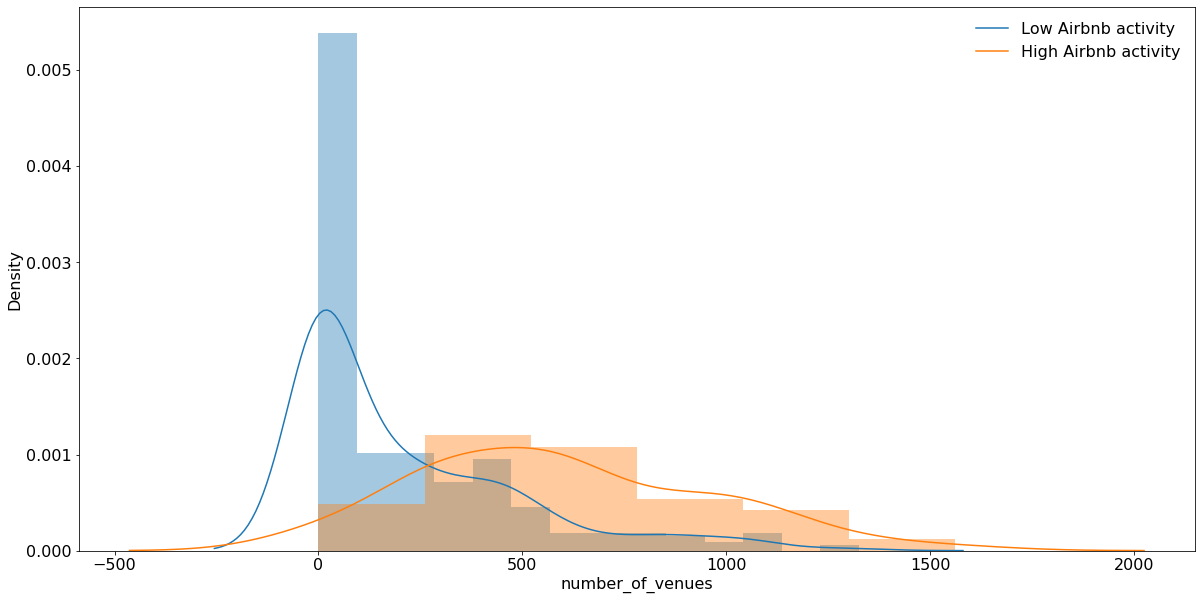

In [31]:
plt.figure(figsize = (20, 10))
sns.distplot(df_low['number_of_venues'])

mean_low.append(df_low['number_of_venues'].mean())
stdev_low.append(df_low['number_of_venues'].std())
mean_high.append(df_high['number_of_venues'].mean())
stdev_high.append(df_high['number_of_venues'].std())
#sns.distplot(df_medium['young_adults'])
sns.distplot(df_high['number_of_venues'])
plt.legend(['Low Airbnb activity', 'High Airbnb activity'], frameon = False)

In [32]:
statistics['mean_high'] = mean_high
statistics['mean_low'] = mean_low
statistics['stdev_high'] = stdev_high
statistics['stdev_low'] = stdev_low

In [33]:
statistics

,KS p-val,mean_high,mean_low,stdev_high,stdev_low
young_adults,1.443290e-15,0.370027,0.289276,0.074497,0.061514
children,3.588463e-12,0.133862,0.186460,0.044008,0.049177
low_income,1.808910e-04,16.309375,11.885143,8.729874,7.785973
medium_income,3.626562e-06,25.089062,28.506286,4.971159,5.863780
median_household_income,8.278389e-02,58024.953125,64576.565714,26980.404343,27588.310315
households,2.244472e-03,14061.968750,10754.195467,6062.308018,5934.694759
number_of_venues,1.443290e-15,596.937500,207.583569,354.676328,274.929494


In [34]:
df_high

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
12,78751,TX,426,1487.0,4390,0.092999,0.465826,16.4,24.8,45726.0,7388,364
14,78705,TX,509,1922.0,4293,0.017622,0.153960,54.8,12.3,12385.0,8704,477
16,78722,TX,205,822.0,2335,0.123751,0.481159,7.1,33.1,64929.0,2973,231
...,...,...,...,...,...,...,...,...,...,...,...,...
331,91748,CA,355,1202.0,7183,0.143221,0.276984,9.8,31.2,58502.0,13476,0
353,90405,CA,299,973.0,3499,0.119972,0.337921,14.5,24.7,77948.0,14254,629
355,90803,CA,224,864.0,2941,0.094579,0.351698,6.5,31.6,75197.0,16995,0
356,90802,CA,312,931.0,4618,0.136075,0.392364,18.9,27.2,42829.0,20636,0


In [35]:
variables = list(statistics.index)
variables

['young_adults',
 'children',
 'low_income',
 'medium_income',
 'median_household_income',
 'households',
 'number_of_venues']

<Figure size 1440x1728 with 0 Axes>

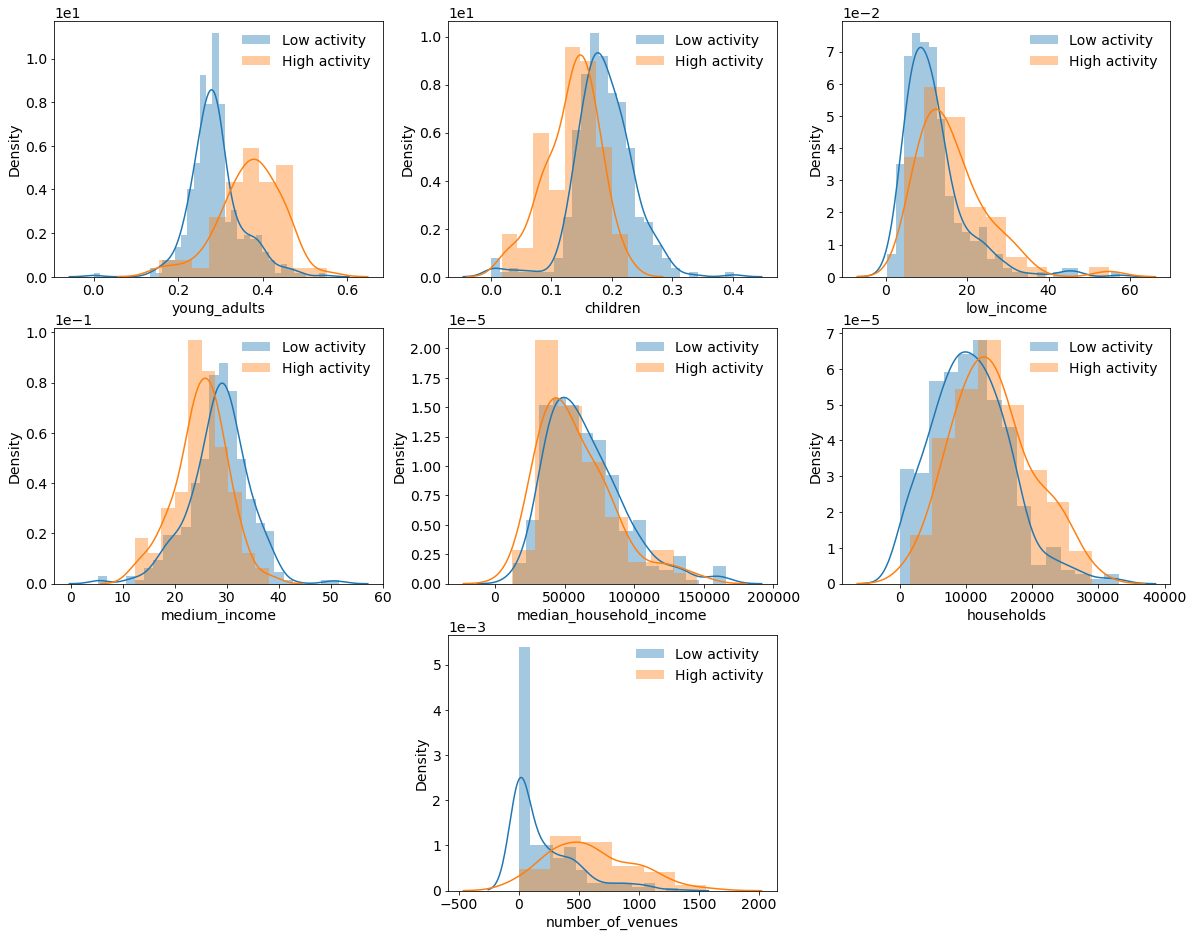

In [36]:
plt.figure(figsize = (20, 24))
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(3, 3, figsize  = (20, 16))

for i in range(len(variables) - 1):
    var = variables[i]
    sns.distplot(df_low[var], label = 'Low activity', ax = ax[i//3, i%3])
    sns.distplot(df_high[var], label = 'High activity', ax = ax[i//3, i%3])
    
    handles, labels = ax[i//3, i%3].get_legend_handles_labels()
    order = [0,1]
    ax[i//3, i%3].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 1, frameon = False)
    ax[i//3, i%3].ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
    #ax[i//3, i%3].set_xlabel("")

var = 'number_of_venues'
sns.distplot(df_low[var], label = 'Low activity', ax = ax[2, 1])
sns.distplot(df_high[var], label = 'High activity', ax = ax[2, 1])
    
handles, labels = ax[2, 1].get_legend_handles_labels()
order = [0,1]
ax[2,1].legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 1, frameon = False)
ax[2, 1].ticklabel_format(style = 'sci', axis = 'y', scilimits = (0,0))
#ax[2, 1].set_xlabel("")

fig.delaxes(ax[2,0])
fig.delaxes(ax[2,2])

plt.savefig("./distributions_.pdf")
    
    

In [37]:
statistics

,KS p-val,mean_high,mean_low,stdev_high,stdev_low
young_adults,1.443290e-15,0.370027,0.289276,0.074497,0.061514
children,3.588463e-12,0.133862,0.186460,0.044008,0.049177
low_income,1.808910e-04,16.309375,11.885143,8.729874,7.785973
medium_income,3.626562e-06,25.089062,28.506286,4.971159,5.863780
median_household_income,8.278389e-02,58024.953125,64576.565714,26980.404343,27588.310315
households,2.244472e-03,14061.968750,10754.195467,6062.308018,5934.694759
number_of_venues,1.443290e-15,596.937500,207.583569,354.676328,274.929494


In [38]:
print(statistics.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      KS p-val &     mean\_high &      mean\_low &    stdev\_high &     stdev\_low \\
\midrule
young\_adults            &  1.443290e-15 &      0.370027 &      0.289276 &      0.074497 &      0.061514 \\
children                &  3.588463e-12 &      0.133862 &      0.186460 &      0.044008 &      0.049177 \\
low\_income              &  1.808910e-04 &     16.309375 &     11.885143 &      8.729874 &      7.785973 \\
medium\_income           &  3.626562e-06 &     25.089062 &     28.506286 &      4.971159 &      5.863780 \\
median\_household\_income &  8.278389e-02 &  58024.953125 &  64576.565714 &  26980.404343 &  27588.310315 \\
households              &  2.244472e-03 &  14061.968750 &  10754.195467 &   6062.308018 &   5934.694759 \\
number\_of\_venues        &  1.443290e-15 &    596.937500 &    207.583569 &    354.676328 &    274.929494 \\
\bottomrule
\end{tabular}



# Part 6: activity within the most active zipcodes

In [102]:
df_high

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
12,78751,TX,426,1487.0,4390,0.092999,0.465826,16.4,24.8,45726.0,7388,364
14,78705,TX,509,1922.0,4293,0.017622,0.153960,54.8,12.3,12385.0,8704,477
16,78722,TX,205,822.0,2335,0.123751,0.481159,7.1,33.1,64929.0,2973,231
...,...,...,...,...,...,...,...,...,...,...,...,...
331,91748,CA,355,1202.0,7183,0.143221,0.276984,9.8,31.2,58502.0,13476,0
353,90405,CA,299,973.0,3499,0.119972,0.337921,14.5,24.7,77948.0,14254,629
355,90803,CA,224,864.0,2941,0.094579,0.351698,6.5,31.6,75197.0,16995,0
356,90802,CA,312,931.0,4618,0.136075,0.392364,18.9,27.2,42829.0,20636,0


In [42]:
avg_occ_by_zip = pd.read_csv("./avg_occ_rate_by_zipcode.csv")

In [43]:
avg_occ_by_zip['average_occupancy'] = avg_occ_by_zip['occupied_per']

In [44]:
df_high = df_high.merge(avg_occ_by_zip, how = 'left', on = 'zipcode')

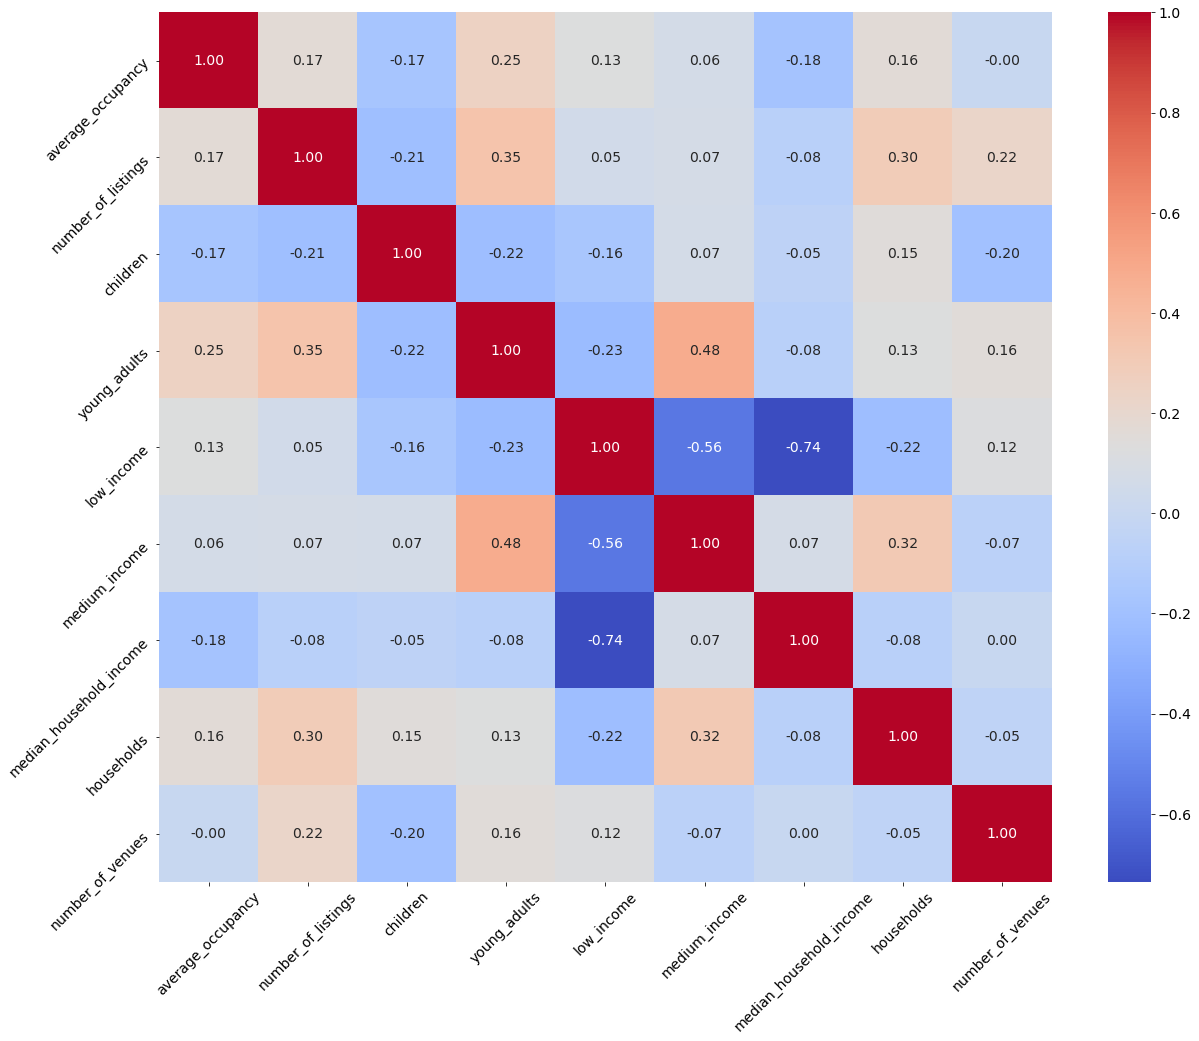

In [61]:
correlation = df_high[['average_occupancy', 'number_of_listings', 'children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'households', 'number_of_venues']].corr()

plt.figure(figsize = (20, 16))

sns.heatmap(correlation,annot=True, fmt = ".2f", cmap = "coolwarm")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.savefig("corrmap2.pdf")

In [46]:
df_high

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues,occupied_per,average_occupancy
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915,0.162314,0.162314
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152,0.174727,0.174727
2,78751,TX,426,1487.0,4390,0.092999,0.465826,16.4,24.8,45726.0,7388,364,0.277162,0.277162
3,78705,TX,509,1922.0,4293,0.017622,0.153960,54.8,12.3,12385.0,8704,477,0.317770,0.317770
4,78722,TX,205,822.0,2335,0.123751,0.481159,7.1,33.1,64929.0,2973,231,0.267693,0.267693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,91748,CA,355,1202.0,7183,0.143221,0.276984,9.8,31.2,58502.0,13476,0,0.143145,0.143145
60,90405,CA,299,973.0,3499,0.119972,0.337921,14.5,24.7,77948.0,14254,629,0.239003,0.239003
61,90803,CA,224,864.0,2941,0.094579,0.351698,6.5,31.6,75197.0,16995,0,0.211404,0.211404
62,90802,CA,312,931.0,4618,0.136075,0.392364,18.9,27.2,42829.0,20636,0,0.222958,0.222958


State NC
2
0.16852047778507684
State TX
11
0.2618382623681494
State TN
5
0.1996110441535476
State LA
7
0.21984983482014978
State CA
39
0.2201617316826203


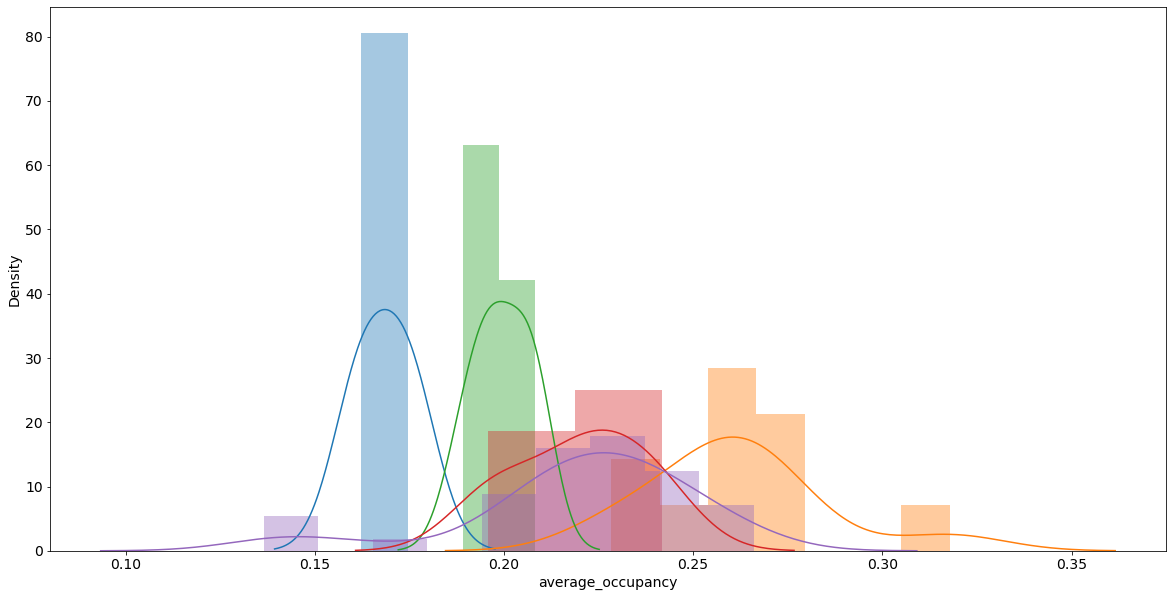

In [50]:
plt.figure(figsize = (20, 10))

for state in df_high.state.unique():
    print("State " + state)
    print(len(df_high[df_high['state'] == state]))
    print(df_high[df_high['state'] == state]['average_occupancy'].mean())
    sns.distplot(df_high[df_high['state'] == state]['average_occupancy'])

Trying simple linear regression 

In [80]:
from sklearn.linear_model import LinearRegression
import copy

lr = LinearRegression()

train = copy.deepcopy(df2[['children', 'young_adults', 'low_income', 'medium_income', 'median_household_income', 'number_of_listings', 'number_of_venues', 'households']])

train = train.dropna()

X = train[['children', 'young_adults', 'low_income', 'medium_income', 'number_of_venues', 'households', 'median_household_income']]
y = train['number_of_listings']

lr.fit(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [81]:
lr.score(X, y)

# R^2 score of linear regression
# generally speaking, 1 is perfect, 0 is if we predict constant mean value

0.3871673695436961

In [82]:
lr.coef_

array([-9.91250913e+02,  9.64785436e+02,  2.55929018e+00, -4.78210333e+00,
        1.29544575e-01,  7.43872702e-03,  1.11833991e-03])

In [83]:
import statsmodels.api as sm
from scipy import stats

In [84]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     number_of_listings   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     36.64
Date:                Sun, 18 Jul 2021   Prob (F-statistic):           1.16e-39
Time:                        12:10:47   Log-Likelihood:                -2720.0
No. Observations:                 414   AIC:                             5456.
Df Residuals:                     406   BIC:                             5488.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [90]:
df2

,zipcode,state,number_of_listings,overall_capacity,overall_availability,children,young_adults,low_income,medium_income,median_household_income,households,number_of_venues
0,28806,NC,239,821.0,3412,0.190200,0.340500,16.8,27.0,41208.0,16570,915
1,28801,NC,203,660.0,2590,0.132028,0.317692,25.1,19.0,31359.0,6511,1152
2,28803,NC,115,446.0,1916,0.178188,0.281308,13.5,28.3,47474.0,13862,863
3,28805,NC,98,358.0,1433,0.152915,0.257746,13.5,28.5,45335.0,8483,449
4,28804,NC,121,449.0,1984,0.134176,0.226018,11.3,25.9,50193.0,8257,427
...,...,...,...,...,...,...,...,...,...,...,...,...
412,91361,CA,7,15.0,181,0.145984,0.181652,6.1,23.7,104807.0,8539,0
413,91306,CA,39,122.0,817,0.175826,0.315998,9.5,32.5,61529.0,14447,0
414,90606,CA,3,25.0,28,0.182127,0.295256,8.3,36.1,64393.0,8539,8
415,90095,CA,2,9.0,32,NaN,NaN,NaN,NaN,NaN,0,146


In [101]:
listings['clean_zip'] = listings['zipcode'].apply(lambda z: clean(z))
l_mod = copy.deepcopy(listings)

In [104]:
l_mod = l_mod.dropna(subset = ['clean_zip'])

In [112]:
d = {}
for el in df2['zipcode'].unique():
    d[el] = df2[df2['zipcode'] == el]['young_adults'].values[0]

In [115]:
l_mod['young_adults'] = l_mod['clean_zip'].apply(lambda z: d[z] if z in d.keys() else np.nan)
l_mod

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode,overall_activity,clean_zip,young_adults
0,2.0,"{""Wireless Internet"",""Air Conditioning"",Kitche...",0,1.0,Real Bed,1.0,1.0,moderate,Asheville,NaN,...,9.0,96.0,10.0,Entire home/apt,NC,$650.00,28806.0,0.0,28806.0,0.340500
1,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",17,1.0,Real Bed,1.0,2.0,strict,Asheville,NaN,...,9.0,96.0,9.0,Entire home/apt,NC,NaN,28806.0,68.0,28806.0,0.340500
2,1.0,"{TV,""Wireless Internet"",""Air Conditioning"",Kit...",29,1.0,Real Bed,1.0,1.0,flexible,Asheville,NaN,...,NaN,NaN,NaN,Private room,NC,NaN,28806.0,29.0,28806.0,0.340500
3,6.0,"{Internet,""Wireless Internet"",""Air Conditionin...",28,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,NaN,NaN,NaN,Shared room,NC,NaN,28806.0,168.0,28806.0,0.340500
4,6.0,"{Internet,""Wireless Internet"",""Free Parking on...",25,2.5,Real Bed,1.0,6.0,moderate,Asheville,NaN,...,9.0,93.0,10.0,Shared room,NC,NaN,28806.0,150.0,28806.0,0.340500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50316,2.0,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",29,1.0,Real Bed,1.0,1.0,flexible,la habra,NaN,...,NaN,NaN,NaN,Private room,CA,NaN,90631,58.0,90631.0,0.280864
50317,2.0,"{""Wireless Internet"",Kitchen,""Free parking on ...",29,1.0,Real Bed,1.0,1.0,strict,malibu,NaN,...,NaN,NaN,NaN,Private room,CA,NaN,90265,58.0,90265.0,0.168529
50318,10.0,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",29,5.0,Real Bed,5.0,5.0,flexible,malibu,NaN,...,NaN,NaN,NaN,Entire home/apt,CA,NaN,90265,290.0,90265.0,0.168529
50319,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",28,1.0,Real Bed,2.0,2.0,moderate,la habra,NaN,...,NaN,NaN,NaN,Private room,CA,NaN,90631,112.0,90631.0,0.280864


In [117]:
l_mod.columns

Index(['accommodates', 'amenities', 'availability_30', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'cancellation_policy', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'name', 'price', 'property_type',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode', 'overall_activity', 'clean_zip',
       'young_adults'],
      dtype='object')

In [118]:
dfya = l_mod[['id', 'young_adults']]
dfya

,id,young_adults
0,665257,0.340500
1,2746729,0.340500
2,6919450,0.340500
3,12286328,0.340500
4,156926,0.340500
...,...,...
50316,18445825,0.280864
50317,18192212,0.168529
50318,17339165,0.168529
50319,17827299,0.280864


In [119]:
dfya.to_csv("./df_listings_young_adults.csv")

In [100]:
listings['clean_zip'].unique()

array([2.88060e+04, 2.88010e+04, 2.88030e+04, 2.88050e+04, 2.88040e+04,
       2.87870e+04,         nan, 2.87150e+04, 2.87040e+04, 2.87320e+04,
       2.87590e+04, 7.87560e+04, 7.87570e+04, 7.87510e+04, 7.87310e+04,
       7.87050e+04, 7.87470e+04, 7.87220e+04, 7.87520e+04, 7.87390e+04,
       7.87480e+04, 7.87370e+04, 7.87490e+04, 7.87540e+04, 7.87530e+04,
       7.87320e+04, 7.87260e+04, 7.87300e+04, 7.87360e+04, 7.86200e+04,
       7.87120e+04, 7.87340e+04, 7.87380e+04, 7.87250e+04, 7.87240e+04,
       7.87580e+04, 7.87280e+04, 7.87270e+04, 7.87440e+04, 7.87450e+04,
       7.87740e+04, 7.86440e+04, 7.87350e+04, 7.87040e+04, 7.87410e+04,
       7.87460e+04, 7.87190e+04, 7.86170e+04, 7.87420e+04, 7.87020e+04,
       7.87030e+04, 7.87010e+04, 7.87170e+04, 7.87500e+04, 7.87230e+04,
       7.87590e+04, 7.86520e+04, 7.87290e+04, 7.87210e+04, 7.82180e+04,
       7.87330e+04, 9.72020e+04, 3.72090e+04, 3.72180e+04, 3.70150e+04,
       3.71890e+04, 3.70800e+04, 3.72060e+04, 3.72080e+04, 3.721

First 2 coeff are of the opposite sign - that is fine, since the corresponding variables are negatively correlated. Mostly learns information from proportion of young adults and children.

In [29]:
!jupyter nbconvert --to html Notebook1.ipynb

[NbConvertApp] Converting notebook Notebook1.ipynb to html
[NbConvertApp] Writing 885420 bytes to Notebook1.html
